In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import plot_importance
import gc

### XGBoosting Prediction
For the section below, we would be explore the XGBoosting prediction method. XGBoosting stand for extreme gradient boosting and it have successfully won kaggle competitions (https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). The package includes efficient linear model solver linear model solver and tree learning algorithm. It supports regression functions therefore is suitable for our prediction scenario.

In [2]:
def delifexistslist(varlist):
    for var in varlist:
        if var in globals():
            del var
    gc.collect()

def data_grouping(train_data):
    itemCntDayGrouped = train_data.groupby(['item_id','shop_id','date_block_num'])[['item_cnt_day']].agg('sum').reset_index()

    return(itemCntDayGrouped)

def populate_all_item_shop(test, train_data):
    
    itemCntDayGrouped = train_data.groupby(['item_id','shop_id','date_block_num'])[['item_cnt_day']].agg('sum').reset_index()
    
    #Populate a list of required product and shop for kaggle submission
    #This code will ensure that all the product and shop to be available
    #in the data frame regardless there are sales/item count or not. 
    testTemp=test.drop(columns=['ID']).reset_index()
    #Recreate a empty data frame
    salesTable=pd.DataFrame({'date_block_num':[0],'shop_id':[0],'item_id':[0]})
    for i in range(34):  
        testTemp['date_block_num']=i
        testTemp2=testTemp.set_index(['date_block_num','shop_id','item_id'])
        salesPPX=itemCntDayGrouped[itemCntDayGrouped.date_block_num==i].set_index(['date_block_num','shop_id','item_id'])
        testTemp2=testTemp2.join(salesPPX).reset_index().fillna(0)
        salesTable=salesTable.append(testTemp2)

    return(salesTable)

def get_week34_data(test, train_data):
    #Add Test Data month 34 as well
    test_data=test.reset_index().drop(columns=['ID'])
    test_data['date_block_num']=34

    train_data=train_data.append(test_data).fillna(0)
    train_data.drop(columns=['index'])
    
    return(train_data)
    
#Calculate lag for all
def populateLag(all_data, lags): 
    tmp = all_data[['date_block_num','shop_id','item_id','item_cnt_day']]
    i = 1
    while i in range(lags):
        shifted = tmp.copy()
        columnName = 'lags: ' + str(i)
        shifted=shifted.rename(columns={'item_cnt_day':columnName})
        shifted['date_block_num'] += i
        shifted=shifted.set_index(['date_block_num','shop_id','item_id'])
        all_data=all_data.set_index(['date_block_num','shop_id','item_id']).join(shifted).reset_index()
        i += 1
        
    all_data = all_data.drop(columns=['index'])    
    
    return all_data.fillna(0)

def get_rmse_by_week(data, week1, week2):
    ModelData201509=data[data.date_block_num==32].values
    ModelData201510=data[data.date_block_num==33].values

    rms = mean_squared_error(ModelData201509, ModelData201510, squared=False)
    print('RMSE for 201509->201510 Regession:'+str(rms))

def gxb_data_split(data):
    #Create Train, Validation Set
    x_train=data[data.date_block_num<33].drop(columns=['item_cnt_day'])
    y_train=data[data.date_block_num<33]['item_cnt_day'].values
    x_valid=data[data.date_block_num==33].drop(columns=['item_cnt_day'])
    y_valid=data[data.date_block_num==33]['item_cnt_day'].values
    x_target=data[data.date_block_num==34].drop(columns=['item_cnt_day'])
    
    return x_train, y_train, x_valid, y_valid, x_target

def cal_k_fold(model4, x_train, y_train):
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(model4, x_train, y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
    print("K-fold standard deviation score: %.2f" % kf_cv_scores.std())
    
def predict_data(model4, itemCntLag, x_target):
    modelOutput = model4.predict(x_target)
    x_target['item_cnt_day'] = modelOutput
    
    return itemCntLag.append(x_target,ignore_index=False)

def plot_predicted_data(combinedData):
    combinedData = combinedData.groupby(['date_block_num'])[['item_cnt_day']].agg('sum').reset_index()
    
    fig0,ax0=plt.subplots(figsize=(20,8));
    sns.lineplot(x='date_block_num', y = 'item_cnt_day', data = combinedData)

    plt.title("Total Item Count", fontsize = 20)
    plt.xlabel("Date Block Number", fontsize = 15)
    plt.ylabel("Total Item Count", fontsize = 15)
    plt.show()
    
def get_prediction_model_feature_important():
    model4.get_booster().get_score(importance_type='weight')
    fig, ax = plt.subplots(1,1,figsize=(15,20))
    plot_importance(booster=model4, ax=ax)

def get_submission_for_kaggle():
    Predictions = np.rint(modelOutput)
    Predictions
    df = pd.DataFrame(Predictions)

### Predict Nov 2015 item count

Read data from CSV for prediction

In [3]:
train = pd.read_csv('predictFutureSalesClean.csv')
items = pd.read_csv("items.csv")
test = pd.read_csv("test.csv")

#### Populate Missing Item ID, Shop Id and Date Block Number

To ensure that we have the exact list of item and item_block_num requried for prediction/submission, the code below 
will populate all missing item_id, shop_id, item_block_num with itm_cnt_day = 0. 

In [4]:
itemCntDayGrouped = populate_all_item_shop(test, train)

In [5]:
itemCntDayGrouped

,date_block_num,shop_id,item_id,index,item_cnt_day
0,0,0,0,NaN,NaN
0,0,5,5037,0.0,0.0
1,0,5,5320,1.0,0.0
2,0,5,5233,2.0,0.0
3,0,5,5232,3.0,0.0
...,...,...,...,...,...
214195,33,45,18454,214195.0,1.0
214196,33,45,16188,214196.0,0.0
214197,33,45,15757,214197.0,0.0
214198,33,45,19648,214198.0,0.0


#### Populate Week 34 data

To do the prediction for week 34, we will need to populate the Item ID, Shop Id and Date Block Number accordingly.

In [6]:
prepared_data = get_week34_data(test, itemCntDayGrouped)

In [7]:
prepared_data

,date_block_num,shop_id,item_id,index,item_cnt_day
0,0,0,0,0.0,0.0
0,0,5,5037,0.0,0.0
1,0,5,5320,1.0,0.0
2,0,5,5233,2.0,0.0
3,0,5,5232,3.0,0.0
...,...,...,...,...,...
214195,34,45,18454,214195.0,0.0
214196,34,45,16188,214196.0,0.0
214197,34,45,15757,214197.0,0.0
214198,34,45,19648,214198.0,0.0


#### Populate Sales Lag

One of the important feature to do sales prediction is the Sales lag. 

We will be populate sales lag of 3, lag value for past 3 months for the data row. 

In [8]:
itemCntLag = populateLag(prepared_data, 4)

In [9]:
itemCntLag

,date_block_num,shop_id,item_id,item_cnt_day,lags: 1,lags: 2,lags: 3
0,0,0,0,0.0,0.0,0.0,0.0
1,0,5,5037,0.0,0.0,0.0,0.0
2,0,5,5320,0.0,0.0,0.0,0.0
3,0,5,5233,0.0,0.0,0.0,0.0
4,0,5,5232,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7496996,34,45,18454,0.0,1.0,0.0,0.0
7496997,34,45,16188,0.0,0.0,0.0,0.0
7496998,34,45,15757,0.0,0.0,0.0,0.0
7496999,34,45,19648,0.0,0.0,0.0,0.0


#### Prediction Model Training

Before starting the model training, the below will calculate the generate RMSE between date_block_num 32 and date_block_num 33. 

In [10]:
get_rmse_by_week(itemCntLag, 33, 34)

RMSE for 201509->201510 Regession:2.0266654754003364


To train the data we will be slicing the data as below:

Traing Data set = date_block_num < 33<br> 
Validation Data Set = date_block_num == 33<br> 
Preidiction Data Set = date_block_num == 34

In [11]:
x_train, y_train, x_valid, y_valid, x_target = gxb_data_split(itemCntLag)

In the section below, we will train the prediction model and rmse is shown as below: 

In [12]:
%%time
model4 = XGBRegressor(
    max_depth=10,
    booster='gbtree',
    n_estimators=50,
    min_child_weight=0.5, 
    subsample=0.8,
    sampling_method="uniform",
    colsample_bynode=1,
    colsample_bytree=0.8, 
    eta=0.1,
    seed=0)

model4.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:3.12629	validation_1-rmse:5.49618
[1]	validation_0-rmse:3.02436	validation_1-rmse:5.42524
[2]	validation_0-rmse:2.85062	validation_1-rmse:5.36610
[3]	validation_0-rmse:2.75906	validation_1-rmse:5.31082
[4]	validation_0-rmse:2.66983	validation_1-rmse:5.27498
[5]	validation_0-rmse:2.60103	validation_1-rmse:5.24051
[6]	validation_0-rmse:2.48229	validation_1-rmse:5.20213
[7]	validation_0-rmse:2.41951	validation_1-rmse:5.17192
[8]	validation_0-rmse:2.37440	validation_1-rmse:5.14286
[9]	validation_0-rmse:2.32597	validation_1-rmse:5.12223
[10]	validation_0-rmse:2.29363	validation_1-rmse:5.10409
[11]	validation_0-rmse:2.25868	validation_1-rmse:5.08193
[12]	validation_0-rmse:2.22828	validation_1-rmse:5.06087
[13]	validation_0-rmse:2.19783	validation_1-rmse:5.04982
[14]	validation_0-rmse:2.17702	validation_1-rmse:5.04101
[15]	validation_0-rmse:2.15327	validation_1-rmse:5.03195
[16]	validation_0-rmse:2.13117	validation_1-rmse:5.02388
[17]	validation_0-rmse:2.11348	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, sampling_method='uniform',
             scale_pos_weight=1, seed=0, subsample=0.8, tree_method='approx',
             validate_parameters=1, verbosity=None)

The below section will show the K-Fold cross validation score.

In [13]:
cal_k_fold(model4, x_train, y_train)

K-fold CV average score: 0.65
K-fold standard deviation score: 0.06


#### Prediction Model Feature Importance

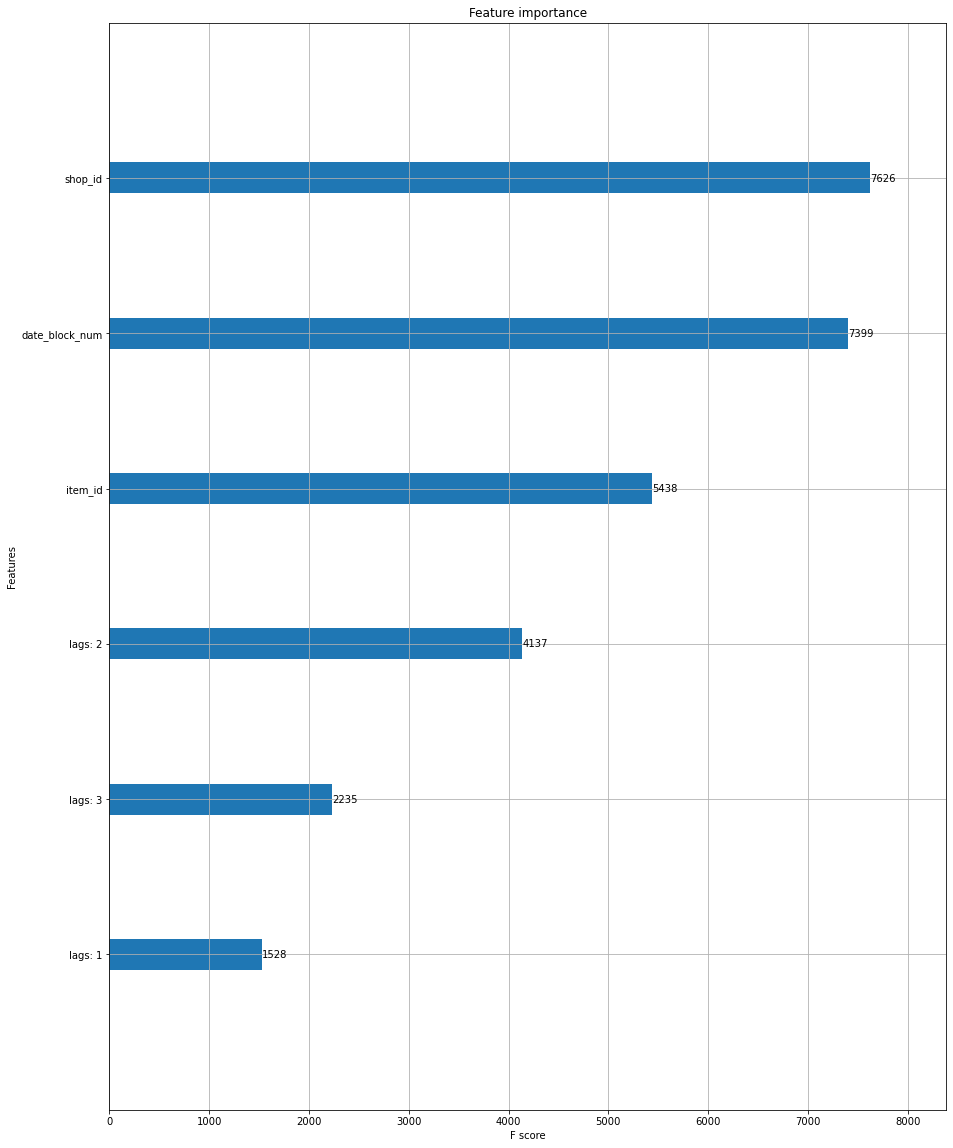

In [14]:
model4.get_booster().get_score(importance_type='weight')

fig, ax = plt.subplots(1,1,figsize=(15,20))
plot_importance(booster=model4, ax=ax)

### Prediction for date_block_num 34

In [15]:
combinedData = predict_data(model4,itemCntLag, x_target)

combinedData

,date_block_num,shop_id,item_id,item_cnt_day,lags: 1,lags: 2,lags: 3
0,0,0,0,0.000000,0.0,0.0,0.0
1,0,5,5037,0.000000,0.0,0.0,0.0
2,0,5,5320,0.000000,0.0,0.0,0.0
3,0,5,5233,0.000000,0.0,0.0,0.0
4,0,5,5232,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7496996,34,45,18454,0.245864,1.0,0.0,0.0
7496997,34,45,16188,0.067317,0.0,0.0,0.0
7496998,34,45,15757,0.067317,0.0,0.0,0.0
7496999,34,45,19648,0.066985,0.0,0.0,0.0


The section below will look into the graph of item_cnt_day by date_block_num(0 - 34)

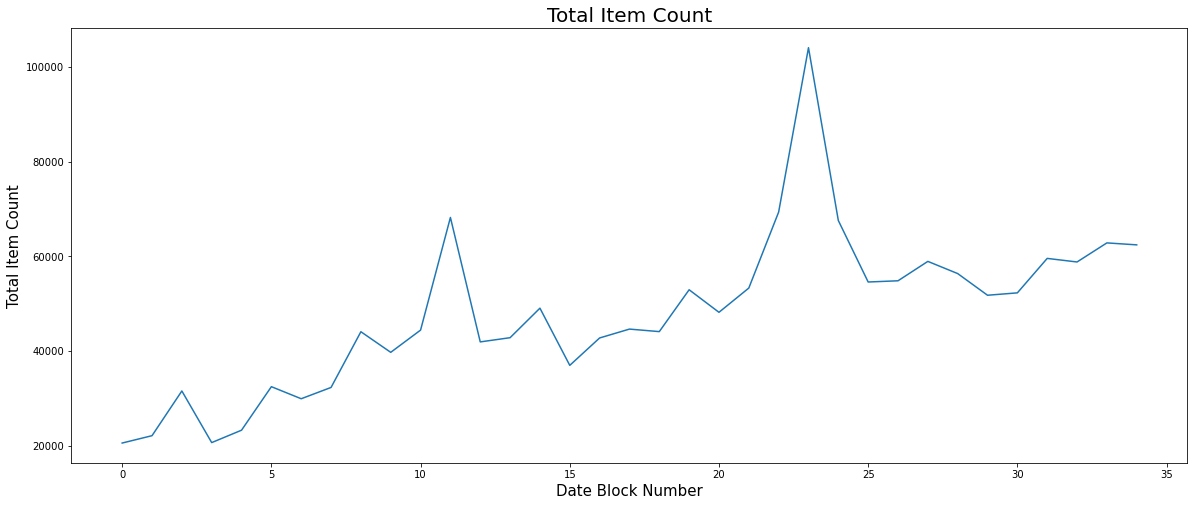

In [16]:
combinedData = combinedData.groupby(['date_block_num'])[['item_cnt_day']].agg('sum').reset_index()

plot_predicted_data(combinedData)

### Submission for Kaggle

In [17]:
x_target

,date_block_num,shop_id,item_id,lags: 1,lags: 2,lags: 3,item_cnt_day
7282801,34,5,5037,0.0,1.0,3.0,0.717455
7282802,34,5,5320,0.0,0.0,0.0,0.106644
7282803,34,5,5233,1.0,3.0,1.0,1.139031
7282804,34,5,5232,0.0,0.0,1.0,0.241485
7282805,34,5,5268,0.0,0.0,0.0,0.106644
...,...,...,...,...,...,...,...
7496996,34,45,18454,1.0,0.0,0.0,0.245864
7496997,34,45,16188,0.0,0.0,0.0,0.067317
7496998,34,45,15757,0.0,0.0,0.0,0.067317
7496999,34,45,19648,0.0,0.0,0.0,0.066985


In [18]:
# Submission for Kaggle
#SalesTest1=pd.read_csv('test.csv')
#SalesTest=SalesTest1.set_index(['shop_id','item_id'])

#PredsDF=x_target[['shop_id','item_id',"item_cnt_day"]]
#Submission=SalesTest.join(PredsDF.set_index(['shop_id','item_id'])).reset_index().drop(columns=['shop_id','item_id'])

#Submission